Note: This code is part of the code I wrote as my submission for the mini project from PHAS0056 Practical Machine Learning.

# Introduction

In this notebook, Convolutional Neural Network is developed to classify LHC jets from W bosons and QCD, using imaging technique. Images display transverse energy of the jet deposited in detectors. Jets from W bosons are considered signal and those from QCD - background.
Data taken from: https://www.hep.ucl.ac.uk/undergrad/0056/other/projects/jetimage/

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from tensorflow.keras.utils import to_categorical
from tensorflow.python.client import device_lib

In [2]:
local_devices = device_lib.list_local_devices()

for device in local_devices:
    print(f"Device name: {device.name}")
    print(f"Device type: {device.device_type}")
    print(f"Memory limit: {device.memory_limit}")

Device name: /device:CPU:0
Device type: CPU
Memory limit: 268435456


In [3]:
np.random.seed(94) # setting random seed value for reproducibility

# Variables for network compiling:
#loss function
loss_function = 'categorical_crossentropy' #'mean_squared_logarithmic_error' #'mean_squared_error' #'categorical_crossentropy'

vector_length = 40 *40 # Image size

optimizer = 'adam' # optimizer
nb_epochs = 10 # number of epochs for training
multi_gpu_training = False

nb_top_lund_planes = 10000 # Number of top quark jet images to be loaded
nb_QCD_lund_planes = 10000 # Number of qcd jet images to be loaded
nb_W_lund_planes = 10000 # Number of W boson jet images to be loaded
model_name = 'CNN'

do_shuffle = True
save_trained_model = False
test_sample_size = 0.25 # fraction of dataset that will be used for training, in this case 25%, so 5000 of 20 000 images

# Input filename, we begin with 600 - 1500 range of transverse momentum
input_filename = "20190920_pt600.0_1500.0_40bins_10k.npz"

In [4]:
print("loading {} feature vector dataset...".format(vector_length))

# import data from the file
input_data = np.load(input_filename)
top_samples = input_data['top_jet_images'][:nb_top_lund_planes]
w_samples = input_data['W_jet_images'][:nb_W_lund_planes]
qcd_samples = input_data['QCD_jet_images'][:nb_QCD_lund_planes]


# renaming
X_BG = qcd_samples # background
# X_S = top_samples # top quark jets - signal
X_S = w_samples # W boson jets - signal


print("S samples:", len(X_S))
print("BG samples:", len(X_BG))
print("ratio S/BG:", len(X_S) / len(X_BG))


#np.random.shuffle(X_BG)

#Label data
y_S = np.ones(len(X_S)) # signal label "1"
y_BG = np.zeros(len(X_BG)) # background label "0"

# combine images with their labels in arrays
X = np.append(X_S, X_BG, axis=0) 
y = np.append(y_S, y_BG, axis=0)


# CNN architecture is built to take color images. 
# Therefore, input shape is: 1 colour channel + 1 imagege channel (flattened)
X = X.reshape( (X.shape[0], X.shape[1], X.shape[2], 1) )

# Split data into training and testing samples while shuffling for random order
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_sample_size, shuffle=do_shuffle)


# Reshape target vectors
y = to_categorical(y, 2)
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

input_shape = X[0].shape # signle image shape
print("Input vector shape:", input_shape)
print("Number of input samples:", len(X))

loading 1600 feature vector dataset...


S samples: 10000
BG samples: 10000
ratio S/BG: 1.0
Input vector shape: (40, 40, 1)
Number of input samples: 20000


In [5]:
print("X_train has shape: ", X_train.shape , "y_train has shape:", y_train.shape)

X_train has shape:  (15000, 40, 40, 1) y_train has shape: (15000, 2)


There are 15000 images used for training, each of size 40 by 40 with one channel. Respectively, there are 15000 labels for the images, each of shape 2, [0,1] for signal and [1,0] for background. 

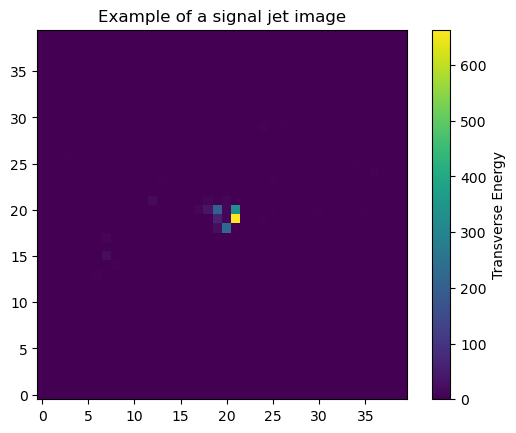

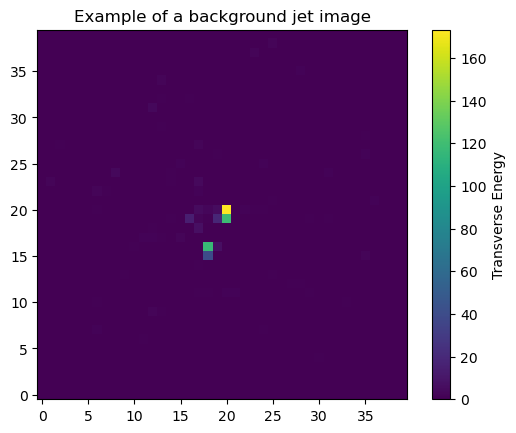

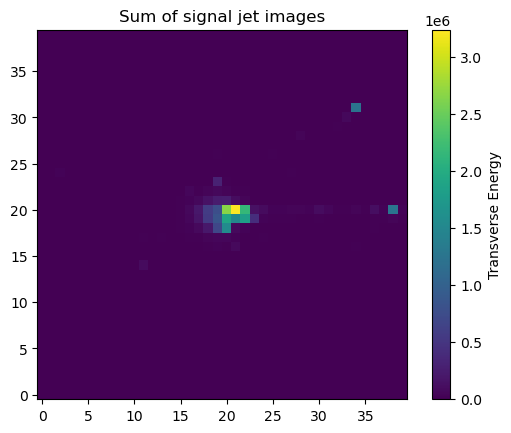

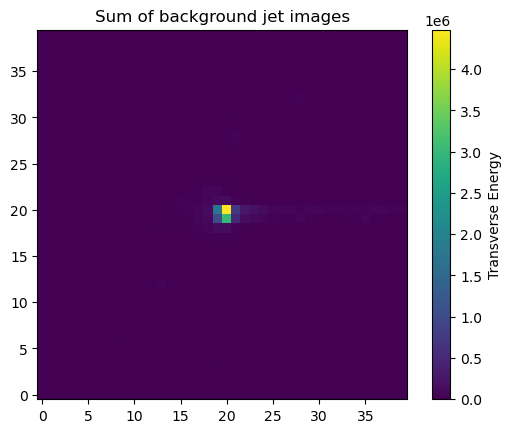

In [6]:
# random number for plotting randomly chosen of images
iimg_sig = np.random.randint(0, len(X_S))
iimg_bkg = np.random.randint(0, len(X_BG)) 

# start figure
fig = plt.figure()
ax = fig.add_subplot(111)

# plot the image
im = ax.imshow(X_S[iimg_sig].reshape(X_S.shape[1], X_S.shape[2]), origin="lower")
ax.set_title("Example of a signal jet image")

# colorbar with label
cbar = fig.colorbar(im)
cbar.ax.set_ylabel('Transverse Energy')

plt.show()


# start figure
fig = plt.figure()
ax = fig.add_subplot(111)

# plot the image
im = ax.imshow(X_BG[iimg_bkg].reshape(X_BG.shape[1], X_BG.shape[2]), origin="lower")
ax.set_title("Example of a background jet image")

# colorbar with label
cbar = fig.colorbar(im)
cbar.ax.set_ylabel('Transverse Energy')

plt.show()


# start figure
fig = plt.figure()
ax = fig.add_subplot(111)

# plot the image
im = ax.imshow(np.sum(X_S, axis=0).reshape(X_S.shape[1], X_S.shape[2]), origin="lower")
ax.set_title("Sum of signal jet images")

# colorbar with label
cbar = fig.colorbar(im)
cbar.ax.set_ylabel('Transverse Energy')

#fig.savefig('jet_image.png', dpi=300)

plt.show()


# start figure
fig = plt.figure()
ax = fig.add_subplot(111)

# plot the image
im = ax.imshow(np.sum(X_BG, axis=0).reshape(X_BG.shape[1], X_BG.shape[2]), origin="lower")
ax.set_title("Sum of background jet images")

# colorbar with label
cbar = fig.colorbar(im)
cbar.ax.set_ylabel('Transverse Energy')

#fig.savefig('jet_image.png', dpi=300)

plt.show()

# Defining the Model

In [7]:
model = keras.models.Sequential()

# first convolutional layer, with 32 filters of size 3x3, input shape (40,40,1)
model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(40, 40, 1)))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2))) # maxpooling 2x2

model.add(keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')) # second convolutional layer with 64 filters
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2))) # maxpooling 2x2

model.add(keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')) # third convolutional layer, 64 filters
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2))) # maxpooling 2x2

# dropout layer for reducing overfitting
model.add(keras.layers.Dropout(0.25))

# begin dense layers, for that flatten input from convolutional layers
model.add(keras.layers.Flatten())

# dense layers
model.add(keras.layers.Dense(256, activation='relu')) # dense layer, 256 nodes
model.add(keras.layers.Dense(128, activation='sigmoid'))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))

model.add(keras.layers.Dense(64, activation='sigmoid'))
model.add(keras.layers.Dense(48, activation='sigmoid'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(16, activation='relu'))

model.add(keras.layers.Dense(2, activation='softmax')) # final layer with two outputs for binary classification

# compile model
model.compile(loss=loss_function, 
              optimizer=keras.optimizers.Adam(learning_rate=0.0004),
              metrics=['accuracy'])

# print model summary
model.summary()

# train model
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=10, 
                    batch_size=64)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 38, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 19, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 64)          36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 64)         0

# Analysis of the network's performance

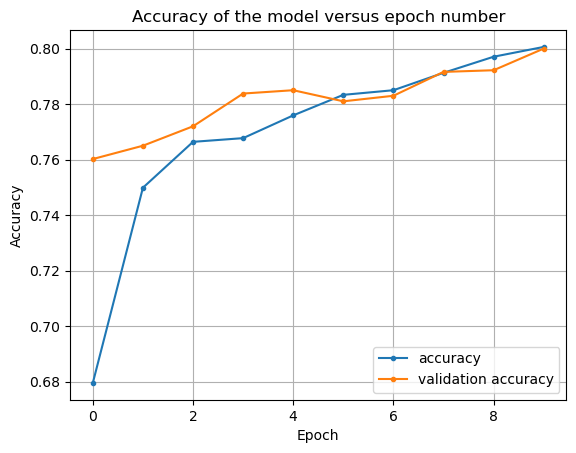

In [8]:
# plot accuracy and validation accuracy vs epoch number
plt.plot(history.history['accuracy'], '.-', label='accuracy')
plt.plot(history.history['val_accuracy'], '.-', label = 'validation accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.6, 0.85])
plt.grid()
plt.title('Accuracy of the model versus epoch number')
plt.legend(loc='lower right')

The final accuracy is slightly above 0.79. It is difficult to tell without any context whether this value is high or low for this specific problem. This is investigated more below. The learning is stopped at 10 epochs, as this is roughly when network stops improving and overfitting starts. As can be seen on the graph, validation accuracy and accuracy are correlated, and the overfitiing at the end is very small. This indicates a good model. Learning rate and number of epochs in the model have been chosen in such a way to minimize overfitting. 

We can also plot loss functions across the epochs. 

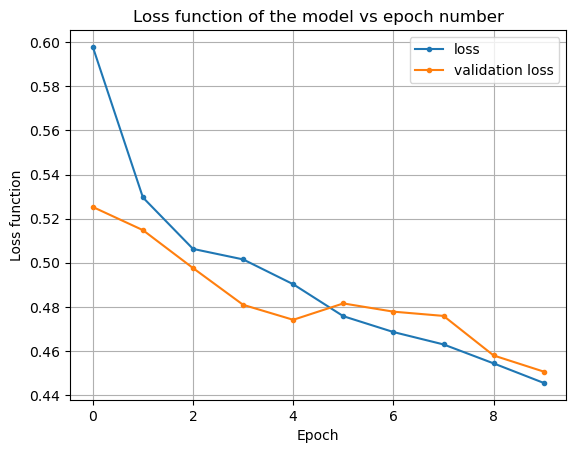

In [9]:
# plot loss and validation loss vs epoch number
plt.plot(history.history['loss'], '.-', label='loss')
plt.plot(history.history['val_loss'], '.-', label = 'validation loss')

plt.xlabel('Epoch')
plt.ylabel('Loss function')
plt.grid()
plt.title('Loss function of the model vs epoch number')
plt.legend(loc = 'best')

Next, we can take a look at those of the images that are misidentified by the model, to see if there are any patterns. 

In [10]:
index = 0 # index for the loop
misidentified_BG = [] # background misidentified as signal list
misidentified_S = [] # signal misidentified as background

# loop over all test images
while index < X_test.shape[0]:
    input_image = X_test[index]

    input_image = input_image.reshape( 1,40,40,1) # reshape for the prediction

    prediction = model.predict(input_image) # model predict

    # since prediction is in form [a,b], where a and b are confidence levels that it is background (a) and signal (b)
    # we can take index number of the greater of those values. E.g if a is greater, then network predicts background
    predicted_class = np.argmax(prediction)


    if prediction[0][0] > prediction[0][1]: # this is predicted as 0
        if y_test[index][1] > y_test[index][0]:
            print("wrong, this is 1 (signal)")
            # predicted as background but it is really signal
            misidentified_S.append(X_test[index]) # update list


    elif y_test[index][0] > y_test[index][1]: 
        print("wrong, this is 0 (background)")
        # predicted as signal, but it is really background
        misidentified_BG.append(X_test[index]) # update list
        
        
    index = index + 1 # index increment

1/1 [==============================] - 0s 274ms/step
wrong, this is 1 (signal)
1/1 [==============================] - 0s 38ms/step
wrong, this is 1 (signal)
1/1 [==============================] - 0s 52ms/step
...wrong, this is 0 (background)
1/1 [==============================] - 0s 37ms/step
wrong, this is 0 (background)
1/1 [==============================] - 0s 43ms/step


In [11]:
# turn lists into arrays
misidentified_BG = np.array(misidentified_BG)
misidentified_S = np.array(misidentified_S)

print("There are ",misidentified_BG.shape[0], "BG misidentified as S")
print("There are",misidentified_S.shape[0], "S misidentified as BG")
print("Total accuracy, on all test images is: ", 1 - (misidentified_BG.shape[0] + misidentified_S.shape[0])/X_test.shape[0])

There are  402 BG misidentified as S
There are 598 S misidentified as BG
Total accuracy, on all test images is:  0.8


It is noticeable that network more often misidentifies signals than backgrounds. This might be a good result, as in some cases it might be better to have less false positives at cost of less true positives. 

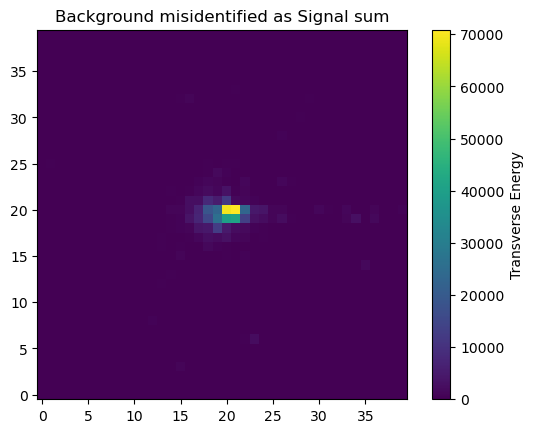

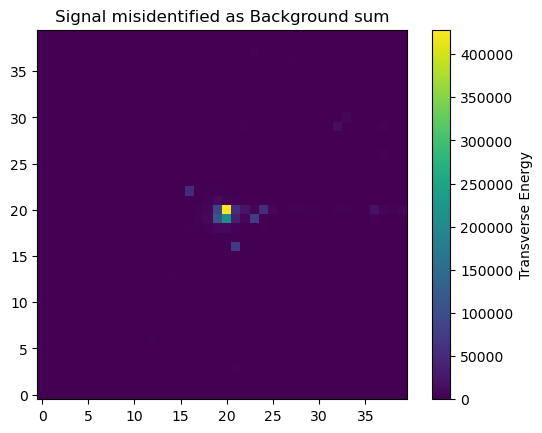

In [12]:
# start figure
fig = plt.figure()
ax = fig.add_subplot(111)

# plot the image
im = ax.imshow(np.sum(misidentified_BG, axis=0).reshape(misidentified_BG.shape[1], misidentified_BG.shape[2]), origin="lower")
ax.set_title("Background misidentified as Signal sum")

# colorbar with label
cbar = fig.colorbar(im)
cbar.ax.set_ylabel('Transverse Energy')
plt.show()



# start figure
fig = plt.figure()
ax = fig.add_subplot(111)

# plot the image
im = ax.imshow(np.sum(misidentified_S, axis=0).reshape(misidentified_S.shape[1], misidentified_S.shape[2]), origin="lower")
ax.set_title("Signal misidentified as Background sum")

# colorbar with label
cbar = fig.colorbar(im)
cbar.ax.set_ylabel('Transverse Energy')
plt.show()

It is noticeable that this time, sum of backgrounds is more spreaded, while the signals sum is more localized. It appears as if the signals and jets switched characteristics. Just by looking at those sums of images, one can notice that sum of backgrounds misidentified as signals resembles sum of signals more than of backgrounds, and sum of signals misidentified as backgrounds, resembles sum of backgrounds. Since sums are just an average image multipled by number of images, it can be concluded that on average, images of signals that network mistakes as background, are similar to background and images of background that network mistakes for signals, are similar to signals. This hints that network's accuracy is limited by the similarity in the data, rather than by the model. 

Further analysis is done, by quantifying similarity using the Structural Similarity Index Measure (SSIM), which is used for classification of similarity of images based on intensity of their pixels and structures included in them. The SSIM score ranges from -1 to 1, with -1 indicating negative correlation, 0 - no similarity and 1 - perfect similarity between two images. 

In [13]:
from skimage.metrics import structural_similarity as ssim

# to focus on the structure, images are normalized by dividing every pixel by maximum value of a pixel in given image
print("Similarity (SSIM score) between signal misidentified as background and signal is: ", 
      ssim(np.sum(misidentified_S, axis=0).reshape(40,40)/np.max(np.sum(misidentified_S, axis=0)),
     np.sum(X_S, axis=0)/np.max(np.sum(X_S, axis=0))))

print("Similarity (SSIM score) between signal misidentified as background and background is: ", 
      ssim(np.sum(misidentified_S, axis=0).reshape(40,40)/np.max(np.sum(misidentified_S, axis=0)),
     np.sum(X_BG, axis=0)/np.max(np.sum(X_BG, axis=0))))


print("Similarity (SSIM score) between background misidentified as signal and background is: ", 
      ssim(np.sum(misidentified_BG, axis=0).reshape(40,40)/np.max(np.sum(misidentified_BG, axis=0)),
     np.sum(X_BG, axis=0)/np.max(np.sum(X_BG, axis=0))) )


print("Similarity (SSIM score) between background misidentified as signal and signal is: ", 
      ssim(np.sum(misidentified_BG, axis=0).reshape(40,40)/np.max(np.sum(misidentified_BG, axis=0)),
     np.sum(X_S, axis=0)/np.max(np.sum(X_S, axis=0))) )

Similarity (SSIM score) between signal misidentified as background and signal is:  0.9259123281475483
Similarity (SSIM score) between signal misidentified as background and background is:  0.9877660924046385
Similarity (SSIM score) between background misidentified as signal and background is:  0.9617939098313174
Similarity (SSIM score) between background misidentified as signal and signal is:  0.9586744485375182


SSIM indicates that signal misidentified as background is more similar to background than to signal. The background misidentified as signal is however slightly more similar to background than to signal, however the difference is very small. SSIM is of course, not perfect and that is why we have to rely on machine learning for this image classification. SSIM has very little parameters compared to complex neural network model built here, it gives us however some context, and partially agrees with observations that can be done by eye regarding similarity. 

Overall, the model can be considered good, as its accuracy is mostly limited by similarity in images. 

Next, we can take a look at the confidence levels predicted by the network. 

In [14]:
sum_predicts = [] # sum of predictions
confidence_that_is_S = [] # confidence that given image is a signal
confidence_that_is_BG = [] # confidence that given image is a background

# loop over test images
for jet_image in X_test:

    # Reshape the input image to match the expected shape of your model's input layer
    input_image = jet_image.reshape( 1,40,40,1)

    # Use the model to make a prediction for the input image
    prediction = model.predict(input_image)


    # Print the predicted class
    predicted_class = np.argmax(prediction)
    #print("Predicted class:", predicted_class)
    
    # update confidence lists with confidence values given by prediction
    confidence_that_is_S.append(prediction[0][1])
    confidence_that_is_BG.append(prediction[0][0])
    
    sum_predicts.append(prediction[0][0] + prediction[0][1]) # update list of sums of predictions

1/1 [==============================] - 0s 32ms/step
...1/1 [==============================] - 0s 43ms/step
1/1 [==============================] - 0s 36ms/step


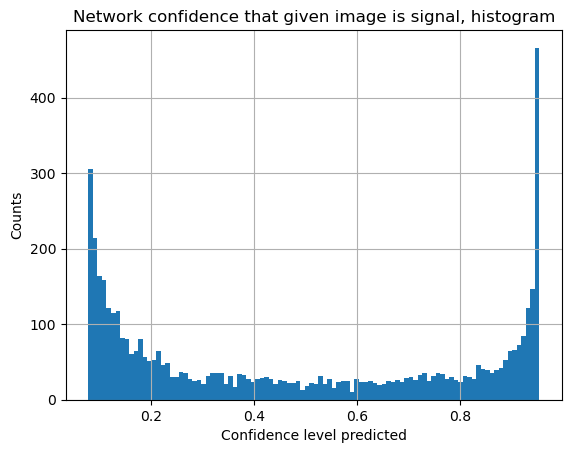

In [15]:
# plotting confidence of Signal classification as a histogram
plt.figure()
plt.hist(confidence_that_is_S,  bins=100)
plt.title("Network confidence that given image is signal, histogram")

plt.xlabel('Confidence level predicted')

plt.savefig('Histogram_network_confidence_that_signal.png', dpi=300)
plt.ylabel('Counts')
plt.grid()

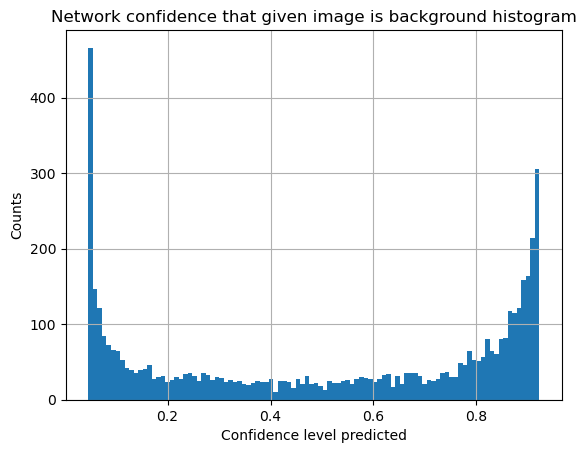

In [16]:
# plotting confidence of Background classification as a histogram
plt.figure()
plt.hist(confidence_that_is_BG,  bins=100)
plt.title("Network confidence that given image is background histogram")

plt.xlabel('Confidence level predicted')
plt.ylabel('Counts')
plt.grid()

As expected the two histograms are reversed, since the softmax function gives probabilities which sum up to 1.0 for all classes. So if network has confidence a that given image is background, its confidence that it is signal is 1-a. 
As expected, the most often occuring values are close to 1 and 0, as those are high confidence levels for either background or signal, indicating that in most cases network is confident in its prediction. There are however, some cases in between, close to 0.5 which suggests that those images were more difficult to classify for the network. 

Next, we can take a look at particular identification probabilities. For example when images are really signal, how confident network is that it is signal. Those are then plotted as histogram.

In [17]:
S_prediction_when_S = [] # what is confidence that it is S when it really is S
BG_prediction_when_BG = []  # what is confidence that it is BG when it really is BG
 
# loop over test images
index = 0
while index < X_test.shape[0]:
    input_image = X_test[index]
    
    # Reshape the input image to match the expected shape of your model's input layer
    input_image = input_image.reshape( 1,40,40,1)
    
    # model's prediction
    prediction = model.predict(input_image)
    
    # labels in y_test are [0,1] for signal and [1,0] for image
    if y_test[index][1] > y_test[index][0]: # this is 1
        S_prediction_when_S.append(prediction[0][1]) # update confidence list
        
    else: # this is 0
        BG_prediction_when_BG.append(prediction[0][0]) # update confidence list
    
    index = index + 1

1/1 [==============================] - 0s 43ms/step
...1/1 [==============================] - 0s 92ms/step
1/1 [==============================] - 0s 33ms/step


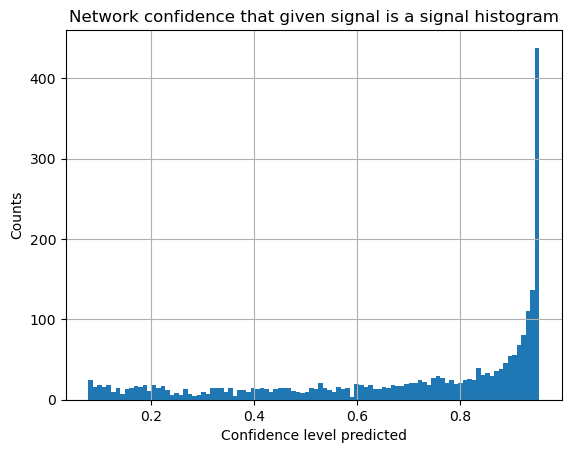

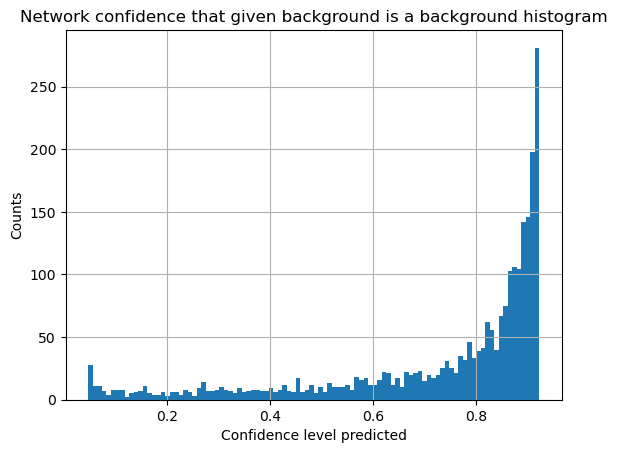

In [18]:
plt.figure()

plt.hist(S_prediction_when_S,  bins=100)

plt.title("Network confidence that given signal is a signal histogram")
plt.xlabel('Confidence level predicted')
plt.ylabel('Counts')
plt.grid()



plt.figure()

plt.hist(BG_prediction_when_BG,  bins=100)

plt.title("Network confidence that given background is a background histogram")
plt.xlabel('Confidence level predicted')
plt.ylabel('Counts')
plt.grid()

As expected, in both of these histograms, the most confidence values are high, indicating that network is confidently making good predictions. In signal identification, there is a lot more low values than in background, with a small peak close to 0. This indicates, that there are some signal images which network finds similar to background, and there are much less background images which network finds similar to signal. This agrees with results from SSIM analysis, which showed that average misidentified signal is more similar to background than to signal, but that average misidentified background is similar to both background and signal.
From those histograms, it can be concluded that the network is good at rejecting background (very little low confidence values for background), but it is slightly worse at identifying signals (some low confidence values indicating that some signals are misidentified as background. 

As further investigation, we can plot the Receiver Operating Characteristic (ROC) curve. ROC can be used to investigate binary classifier, it is a relation of the true positive rate (TPR) to false positive rate (FPR). Those rates are defined as:

$$ TPR = \frac{True Positives Number}{(True Positives Number + False Negatives Number)}$$

$$ FPR = \frac{False Positives Number}{(False Positives Number + True Negatives Number)}$$

A good classifier would have high TPR with simultaneousely low FPR. Random clasifier would have a ROC curve following TPR = FPR line. 

157/157 [==============================] - 2s 14ms/step


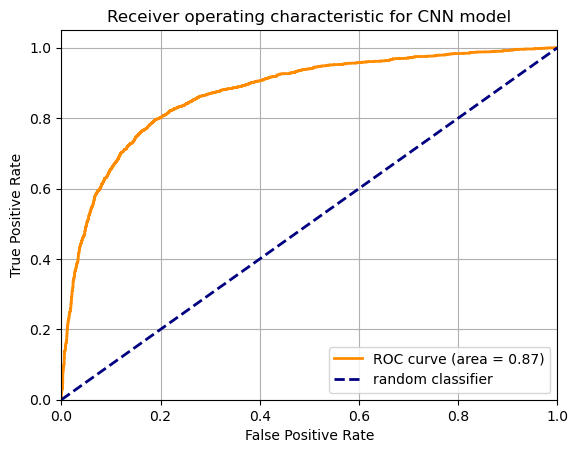

In [19]:
# change labels format
y_test_labels = np.argmax(y_test, axis=1)

# generate predictions
y_pred_prob = model.predict(X_test)

# compute the FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test_labels, y_pred_prob[:,1])

# compute the AUC
roc_auc = roc_auc_score(y_test_labels, y_pred_prob[:,1])

# plot the ROC curve using the FPR and TPR values
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label = 'random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for CNN model')
plt.legend(loc="lower right")
plt.grid()

plt.savefig('ROC_Curve.png', dpi=300)
plt.show()

The ROC curve is above random classifier line as expected. Area under the curve (AUC) is 0.87, which indicates a relatively good classifier, a perfect classifier would have an AUC of 1.0, and random classifier would have an AUC of 0.5. 
The ROC curve, allows for choosing a confidence threshold for classification of images depending on what is needed. For example, if in some cases minimization of false positives must be prioritized, then threshold which grants low FPR should be chosen. On the other hand, in some cases we might want to minimize number of false negatives. In that situation, threshold should be chosen in such a way, as to result in high TPR. In our case, so far network has been using 0.5 as threshold, meaning that class with higher probability of the two is chosen. This can be artificially changed if needed, for example threshold could be lowered for signal classification to 0.4, which would mean that images which had signal concifence level predicted as between 0.5 and 0.4, would now be classified as signals instead of background. Whether the threshold should be unchanged, lowered or increased, depends on the specific situation. 

In [20]:
misidentified_BG_at_thresholds = []
misidentified_S_at_thresholds = []
accuracy_at_thresholds = []
    
for threshold in [-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3]:
    

    index = 0 # index for the loop
    misidentified_BG = [] # background misidentified as signal list
    misidentified_S = [] # signal misidentified as background

    S_threshold_increase = threshold # this will be used for changing threshold for classification

    # loop over all test images
    while index < X_test.shape[0]:
        input_image = X_test[index]

        input_image = input_image.reshape( 1,40,40,1) # reshape for the prediction

        prediction_1 = model.predict(input_image) # model predict


        prediction = np.array([[prediction_1[0][0] - S_threshold_increase
                                , prediction_1[0][1] + S_threshold_increase]])


        predicted_class = np.argmax(prediction)


        if prediction[0][0] > prediction[0][1]: # this is predicted as 0
            if y_test[index][1] > y_test[index][0]:
                print("wrong, this is 1 (signal)")
                # predicted as background but it is really signal
                misidentified_S.append(X_test[index]) # update list


        elif y_test[index][0] > y_test[index][1]: 
            print("wrong, this is 0 (background)")
            # predicted as signal, but it is really background
            misidentified_BG.append(X_test[index]) # update list


        index = index + 1 # index increment
        
        
    # turn lists into arrays
    misidentified_BG = np.array(misidentified_BG)
    misidentified_S = np.array(misidentified_S)

    print("There are ",misidentified_BG.shape[0], "BG misidentified as S")
    print("There are",misidentified_S.shape[0], "S misidentified as BG")
    print("Total accuracy, on all test images is: ", 1 - (misidentified_BG.shape[0] + misidentified_S.shape[0])/X_test.shape[0])
    
    # update lists
    misidentified_BG_at_thresholds.append(misidentified_BG.shape[0])
    misidentified_S_at_thresholds.append(misidentified_S.shape[0])
    accuracy_at_thresholds.append(1 - (misidentified_BG.shape[0] + misidentified_S.shape[0])/X_test.shape[0])

1/1 [==============================] - 0s 38ms/step
wrong, this is 1 (signal)
1/1 [==============================] - 0s 44ms/step
wrong, this is 1 (signal)
...1/1 [==============================] - 0s 49ms/step
wrong, this is 0 (background)
1/1 [==============================] - 0s 40ms/step
wrong, this is 0 (background)
1/1 [==============================] - 0s 46ms/step
There are  1052 BG misidentified as S
There are 211 S misidentified as BG
Total accuracy, on all test images is:  0.7474000000000001


In [21]:
# turn lists into arrays
misidentified_BG = np.array(misidentified_BG)
misidentified_S = np.array(misidentified_S)

print("There are ",misidentified_BG.shape[0], "BG misidentified as S")
print("There are",misidentified_S.shape[0], "S misidentified as BG")
print("Total accuracy, on all test images is: ", 1 - (misidentified_BG.shape[0] + misidentified_S.shape[0])/X_test.shape[0])

There are  1052 BG misidentified as S
There are 211 S misidentified as BG
Total accuracy, on all test images is:  0.7474000000000001


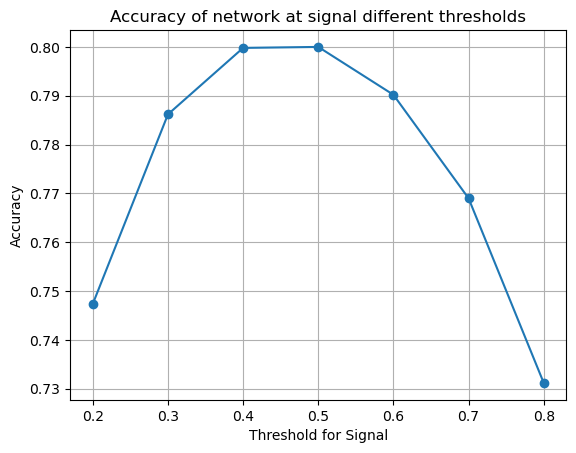

In [22]:
# plot accuracy vs threshold
plt.figure()

plt.plot(0.5 - np.array([-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3]), accuracy_at_thresholds, 'o-')

plt.title('Accuracy of network at signal different thresholds')
plt.xlabel('Threshold for Signal')
plt.ylabel('Accuracy')
plt.grid()

Overall accuracy is the heighest for 0.5 threshold and it is very similar for 0.4 threshold for signal (and therefore 0.6 for background). As expected accuracy is decreasing for very low and very high thresholds, hypothetically in limit of 0 or 1 thresholds, accuracy should be 0.5 as then only half of images would be classified. The threshold should overall be chosen depending on what is needed as mentioned before. 

157/157 [==============================] - 8s 49ms/step


C:\Users\User1\AppData\Local\Temp\ipykernel_27196\2564515837.py:12: RuntimeWarning: divide by zero encountered in true_divide
  rejection_rate = 1 / fpr
C:\Users\User1\AppData\Local\Temp\ipykernel_27196\2564515837.py:19: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1/tpr, "--", label = 'random classifier')


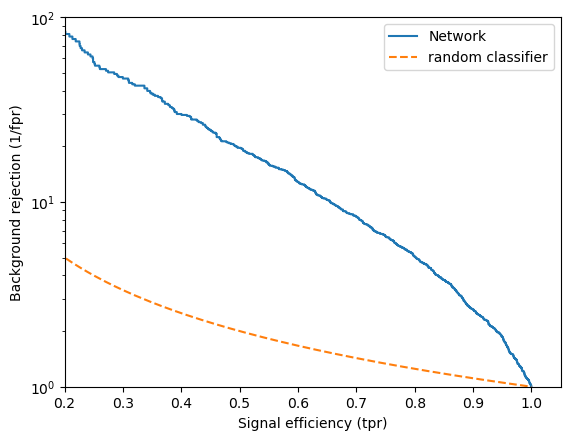

In [23]:
# obtain predicted probabilities for test data
y_pred_proba = model.predict(X_test)

y_true = np.argmax(y_test, axis=1)

y_true = y_true.reshape(5000,1)

# compute fpr, tpr, and thresholds using roc_curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:,1])

# compute rejection rate (1/fpr) and signal efficiency (tpr)
rejection_rate = 1 / fpr
signal_efficiency = tpr

# plot the rejection/efficiency curve
plt.semilogy(signal_efficiency, rejection_rate, label = 'Network')


plt.semilogy(tpr, 1/tpr, "--", label = 'random classifier')

plt.xlabel('Signal efficiency (tpr)')
plt.ylabel('Background rejection (1/fpr)')
plt.xlim(left=0.2)
plt.ylim(1,100)
plt.legend()
plt.savefig('Background_rejection_efficiency.png', dpi=300)
plt.show()

In [24]:
# find rejection rate at 50% signal efficiency
idx_50 = np.where(signal_efficiency >= 0.5)[0][0]
rejection_rate_50 = rejection_rate[idx_50]

# find rejection rate at 80% signal efficiency
idx_80 = np.where(signal_efficiency >= 0.8)[0][0]
rejection_rate_80 = rejection_rate[idx_80]

# print results
print("Rejection rate at 50% signal efficiency: {:.2f}".format(rejection_rate_50))
print("Rejection rate at 80% signal efficiency: {:.2f}".format(rejection_rate_80))

Rejection rate at 50% signal efficiency: 19.62
Rejection rate at 80% signal efficiency: 5.05
